In [1]:
import datetime as dt

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import warnings

from GoogleEarth import GoogleEarth
from Simulator import Simulator

warnings.filterwarnings("ignore")

In [2]:
# Data
df_gases = pd.DataFrame(index=["VC", "BE", "2-EHA", "IB", "BA", "BZ"])
df_gases["Capacity"] = [490000, 114000, 98000, 114000, 114000, 228000]  # The compressed volume in L
df_gases["Mass"] = [402500, 84255, 93400, 70600, 81650, 177000]  # The mass in kg
df_shp = gpd.read_file("../data/geoshape/cb_2018_us_cbsa_20m/cb_2018_us_cbsa_20m.shp")

In [34]:
from collections import defaultdict
import datetime as dt
import math
from typing import Dict, List, Optional, Tuple

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

from shapely.geometry import Point
import pandas as pd

from GoogleEarth import GoogleEarth


class Simulator(object):
    def __init__(self,
                 start_time: dt.datetime,
                 end_time: dt.datetime,
                 source: Tuple[float],
                 iteration_interval: dt.timedelta,
                 simulate_interval: dt.timedelta,
                 google_earth: GoogleEarth,
                 precision: int = 2):
        """A simulator for the disperson

        Args:
            start_time (dt.datetime): The start time of the disperson
            end_time (dt.datetime): The start time of the disperson
            source (Tuple[float]): The x, y coordinate of the source
            iteration_interval (dt.timedelta): The timedelta for each iteration
            simulate_interval (dt.timedelta): The timedelta for each wind simulation
            google_earth (GoogleEarth): Google Earth API
            precision (int): The precision of simulation
        """
        self.time = start_time
        self.end_time = end_time
        self.iteration_interval = iteration_interval
        self.simulation_interval = simulate_interval.seconds
        self.google_earth = google_earth
        self.status = dict()
        # 1 degree in latitude is equal to 111690m
        self.move = 111690 * np.array([math.cos(source[-1] * math.pi / 180), 1])
        self.move = iteration_interval.seconds / self.move
        self.source = tuple(round(i, precision) for i in source)
        self.precision = precision

    def apply_wind(self,
                   df_coordinates: List[List[float]],
                   new_status: Dict[Tuple[float], float]) -> np.array:
        """Get wind data from google earth and apply it on the coordinates

        Args:
            df_coordinates (pd.DataFrame): A dataframe with coordinates

        Returns:
            (pd.DataFrame): A new dataframe with updated coordinates
        """
        df_coordinates = pd.DataFrame(df_coordinates, columns=["x", "y", "p"])
        geo = self.google_earth.get_points_features(df_coordinates["x"],
                                                    df_coordinates["y"],
                                                    ["wind_u", "wind_v"],
                                                    start_time=self.time,
                                                    time_delta=self.iteration_interval).values
        print(geo)
        simulation_count = self.iteration_interval.seconds // self.simulation_interval
        geo = np.repeat(geo, simulation_count, axis=0)
        move = np.tile(np.ones(simulation_count).cumsum(), len(df_coordinates))
        geo[:, :2] += (move.reshape(len(move), 1) * self.move.reshape(1, 2)) * geo[:, -2:]

        particles = np.repeat(df_coordinates["p"], simulation_count) / simulation_count
        for (x, y), particle in zip(geo[:, :2].round(self.precision), particles):
            new_status[(x, y)] += particle

    def step(self):
        new_status = defaultdict(int)
        if self.time <= self.end_time:
            self.status[self.source] = 1

        df_coordinates = list()
        for (x, y), p in self.status.items():
            if p < 1e-4:
                continue
            df_coordinates.append([x, y, p])
            if len(df_coordinates) >= 2500:
                self.apply_wind(df_coordinates, new_status)
                df_coordinates.clear()
        if df_coordinates:
            self.apply_wind(df_coordinates, new_status)
        self.time += self.iteration_interval
        self.status = new_status

    def get_status(self) -> pd.DataFrame:
        """Get current simulation status"""
        df = pd.DataFrame(columns=["X", "Y", "P"])
        for (x, y), p in self.status.items():
            df.loc[len(df)] = [x, y, p]
        return df

    @staticmethod
    def plot_status(df_status: pd.DataFrame,
                    df_shp: gpd.GeoDataFrame,
                    status_time: Optional[dt.datetime] = None):
        """Plot the simulation status"""
        geometry = [Point(xy) for xy in zip(df_status["X"], df_status["Y"])]
        df_geo = gpd.GeoDataFrame(df_status, geometry=geometry, crs="EPSG:4326")
        df_geo = gpd.sjoin(df_geo, df_shp, op="within", how="left")
        df_status = df_shp.set_index(["NAME"])
        df_status["Value"] = df_geo.groupby(["NAME"]).count()["P"]
        df_status["Value"] = df_status["Value"].fillna(0)
        df_status["Value"] = df_status["Value"] / df_status["Value"].sum()
        ax = plt.subplots(figsize=(12.5, 12.5))[1]
        df_status.plot(column="Value", cmap="Reds", linewidth=0.1, edgecolor="white", ax=ax)
        ax.set_xlim(-100, -60)
        ax.set_ylim(25, 55)
        if status_time is not None:
            status_time = status_time.strftime("%Y%m%d %H%M%S")
            ax.set_title(f"Status plot at {status_time}")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")


In [39]:
source = -80.52, 40.84
start_time = dt.datetime(2023, 2, 3, 21)
end_time = dt.datetime(2023, 2, 6, 0)
iteration_interval = dt.timedelta(days=1)
simulator_interval = dt.timedelta(hours=1)
ge = GoogleEarth()
simulator = Simulator(start_time, end_time, source, iteration_interval, simulator_interval, ge, 2)

[[-80.52        40.84         2.05875      0.69666667]]
It takes 0.6291182041168213 to simulate 20230204 210000 status of size 0
[[-80.52        40.84         4.14291667   5.62458333]]
It takes 0.540534496307373 to simulate 20230205 210000 status of size 0
[[-80.52        40.84         2.72875     -0.67708333]]
It takes 0.721254825592041 to simulate 20230206 210000 status of size 0
It takes 0.09734201431274414 to simulate 20230207 210000 status of size 0
It takes 0.11124873161315918 to simulate 20230208 210000 status of size 0
It takes 0.10674786567687988 to simulate 20230209 210000 status of size 0
It takes 0.14794230461120605 to simulate 20230210 210000 status of size 0
It takes 0.0993039608001709 to simulate 20230211 210000 status of size 0
It takes 0.10147929191589355 to simulate 20230212 210000 status of size 0
It takes 0.10338973999023438 to simulate 20230213 210000 status of size 0
It takes 0.0997159481048584 to simulate 20230214 210000 status of size 0
It takes 0.09907650947570

KeyboardInterrupt: 

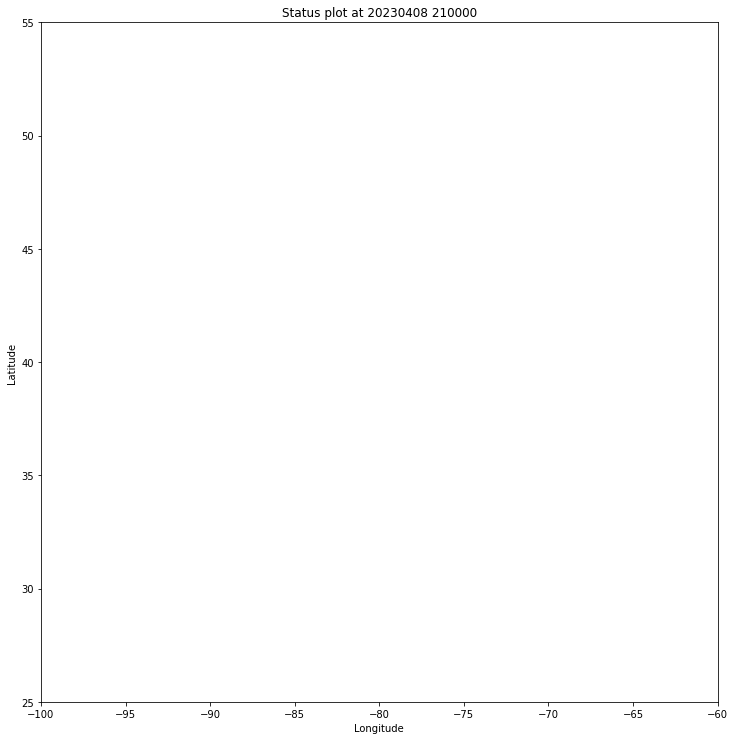

In [40]:
import time

for _ in range(24 * 20):
    t = time.time()
    simulator.step()
    
    status_time = simulator.time
    status = simulator.get_status()
    fig = simulator.plot_status(status, df_shp, status_time)
    status_time = status_time.strftime("%Y%m%d %H%M%S")
    plt.savefig(f"../figures/simulation/{status_time}.png")
    status.to_csv(f"../data/simulation/{status_time}.csv")
    plt.close()
    print(f"It takes {time.time() - t} to simulate {status_time} status of size {len(simulator.status)}")
    

In [78]:
len(simulator.status)

4670